# Reservoir curves - US
***

In [1]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
from pathlib import Path
#import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from tqdm.auto import tqdm
import yaml

from lisfloodreservoirs import read_attributes, read_timeseries
from lisfloodreservoirs.utils.reservoir_curves import *

## Config

In [2]:
country = 'US'
long_name = 'United States'

path_datasets = Path('/home/chus-casado/Datos')

path_plots = Path('./plots/')
path_plots.mkdir(exist_ok=True)

## Data

### ResOpsUS

In [4]:
path_resops = path_datasets / 'reservoirs' / 'ResOpsUS' / 'v2.2'

# list of selected reservoirs
res_list = pd.read_csv(path_resops / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()

# load reservoir attributes
resops_attrs = read_attributes(
    path=path_resops / 'attributes',
    reservoirs=res_list,
    index_col='GRAND_ID',
)

# load time series
resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
    variables=['elevation', 'storage']
)
# keep only reservoirs with both elevation and storage data
resops_ts = {
    grand_id: df for grand_id, df in resops_ts.items() 
    if all(col in df.columns for col in ['elevation', 'storage'])
    }
print(f'/n Number of reservoirs with elevation and storage data: {len(resops_ts)}')
# convert storage units to hm3
for grand_id, df in resops_ts.items():
    if 'storage' in df.columns:
        df.storage *= 1e-6

  0%|          | 0/164 [00:00<?, ?it/s]

Time series for ID 55 is missing variables: {'elevation'}
Time series for ID 57 is missing variables: {'elevation'}
Time series for ID 60 is missing variables: {'elevation'}
Time series for ID 63 is missing variables: {'elevation'}
Time series for ID 131 is missing variables: {'elevation'}
Time series for ID 132 is missing variables: {'elevation'}
Time series for ID 133 is missing variables: {'elevation'}
Time series for ID 148 is missing variables: {'elevation'}
Time series for ID 180 is missing variables: {'elevation'}
Time series for ID 191 is missing variables: {'elevation'}
Time series for ID 193 is missing variables: {'elevation'}
Time series for ID 198 is missing variables: {'elevation'}
Time series for ID 214 is missing variables: {'elevation'}
Time series for ID 297 is missing variables: {'elevation'}
Time series for ID 361 is missing variables: {'elevation'}
Time series for ID 367 is missing variables: {'elevation'}
Time series for ID 372 is missing variables: {'elevation'}
T

### Global Dam Watch

In [5]:
# load GDW reservoirs in the country
path_gdw = path_datasets / 'reservoirs' / 'GDW' / 'GDW_v1_0_shp'
gdw = gpd.read_file(path_gdw / 'GDW_barriers_v1_0.shp').set_index('GRAND_ID')
gdw = gdw[gdw.COUNTRY == long_name]
print(f'GDW contains {len(gdw)} reservoirs in {long_name}')

# reduce reservoirs to those in both GDW and ResOps datasets
grand_ids = gdw.index.intersection(resops_ts.keys())
gdw = gdw.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

GDW contains 4862 reservoirs in United States
138 are both in GDW and ResOps datasets


### Global Water Watch

In [6]:
path_gww = path_datasets / 'reservoirs' / 'GWW'

# load GWW attribute shapefile
gww_attrs = gpd.read_file(path_gww / 'GIS' / f'gww_{country}.shp').set_index('grand_id')
grand_ids = gww_attrs.index.intersection(gdw.index)
gww_attrs = gww_attrs.loc[grand_ids]

# load time series
gww_ts = {}
for grand_id in tqdm(set(gww_attrs.index)):
    try:
        gww_id = gww_attrs.loc[grand_id, 'gww_id'].item()
    except:
        print(f'Multiple intances of GRanD ID {grand_id} in GWW')
        continue

    csv_file = path_gww / 'time_series' / 'raw' / f'{gww_id}.csv'
    if csv_file.is_file():
        # import time series from CSV
        gww_ts[grand_id] = pd.read_csv(csv_file, parse_dates=True, index_col=0)
print(f'{len(gww_ts)} are both in GWW time series')

  0%|          | 0/138 [00:00<?, ?it/s]

Multiple intances of GRanD ID 1033 in GWW
Multiple intances of GRanD ID 597 in GWW
Multiple intances of GRanD ID 1207 in GWW
Multiple intances of GRanD ID 1796 in GWW
Multiple intances of GRanD ID 1872 in GWW
Multiple intances of GRanD ID 870 in GWW
Multiple intances of GRanD ID 989 in GWW
131 are both in GWW time series


## Reservoir curves

In [192]:
# read periods to fit reservoir curves
with open('periods_ResOpsUS.yml', 'r') as f:
    periods = yaml.safe_load(f)

In [ ]:
#periods[657] = {'start': datetime(1990, 1, 1), 'end': datetime(2005, 1, 1)}

  0%|          | 0/138 [00:00<?, ?it/s]


GRanD ID 657
-------------
Points retained (inliers): 5093
Points removed (outliers): 387
Exception: The length of `y` along `axis`=0 doesn't match the length of `x`
start: 1990-01-01 00:00:00
end: 2005-01-01 00:00:00

GRanD ID 753
-------------
Points retained (inliers): 4438
Points removed (outliers): 312
Exception: The 'area' column must be monotonically increasing with 'elevation'. Check data quality.
start: 2000-01-01 00:00:00
end: 2013-01-01 00:00:00

GRanD ID 868
-------------
Points retained (inliers): 11083
Points removed (outliers): 0
WARNING. The binned data is not monotonically increasing
Exception: The 'storage' column must be monotonically increasing with 'elevation'. Check data quality.
start: 1990-01-01 00:00:00
end: 2020-05-05 00:00:00

GRanD ID 870
-------------
Points retained (inliers): 10730
Points removed (outliers): 264
Exception: The 'area' column must be monotonically increasing with 'elevation'. Check data quality.
start: 1990-01-01 00:00:00
end: 2020-02-06 0

/home/chus-casado/GitHub/lisflood-reservoirs/src/lisfloodreservoirs/utils/reservoir_curves.py:661: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize, sharex='col', sharey='row')


Points retained (inliers): 9154
Points removed (outliers): 25
WARNING. The binned data is not monotonically increasing
Exception: The 'storage' column must be monotonically increasing with 'elevation'. Check data quality.
start: 1994-11-01 00:00:00
end: 2020-05-26 00:00:00

GRanD ID 1202
-------------
Points retained (inliers): 10490
Points removed (outliers): 0
Exception: The 'area' column must be monotonically increasing with 'elevation'. Check data quality.
start: 1990-10-01 00:00:00
end: 2021-01-28 00:00:00

GRanD ID 1207
-------------
Points retained (inliers): 6190
Points removed (outliers): 1845
WARNING. The binned data is not monotonically increasing
Exception: The 'storage' column must be monotonically increasing with 'elevation'. Check data quality.
start: 1990-01-01 00:00:00
end: 2020-09-29 00:00:00

GRanD ID 1237
-------------
Points retained (inliers): 11024
Points removed (outliers): 0
Exception: The 'area' column must be monotonically increasing with 'elevation'. Check d

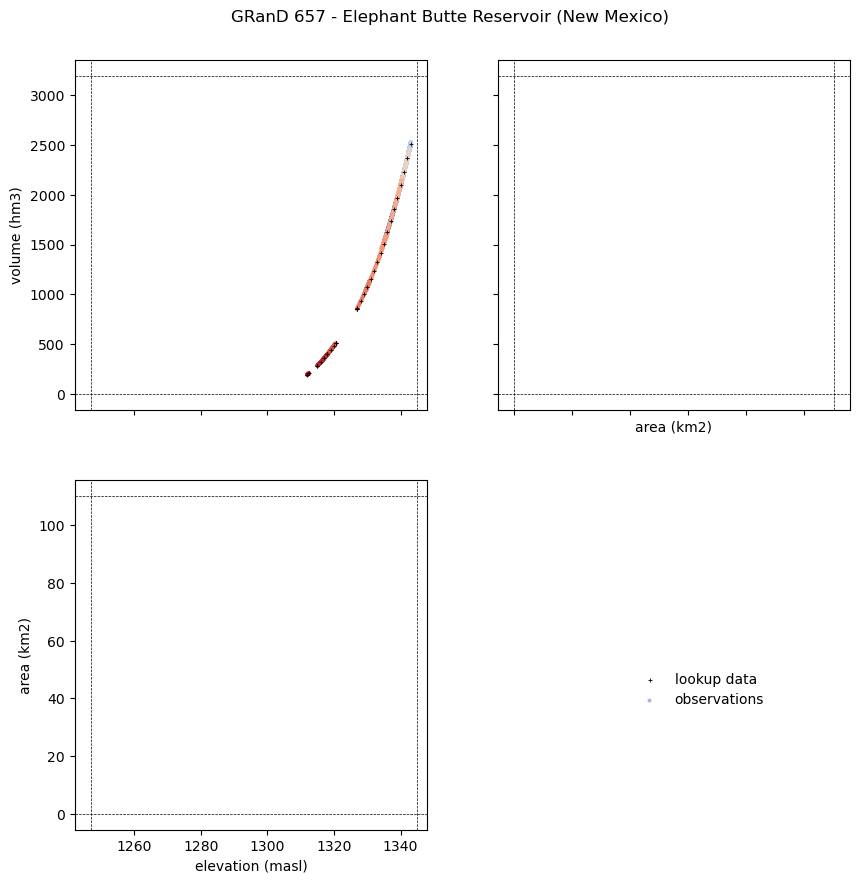

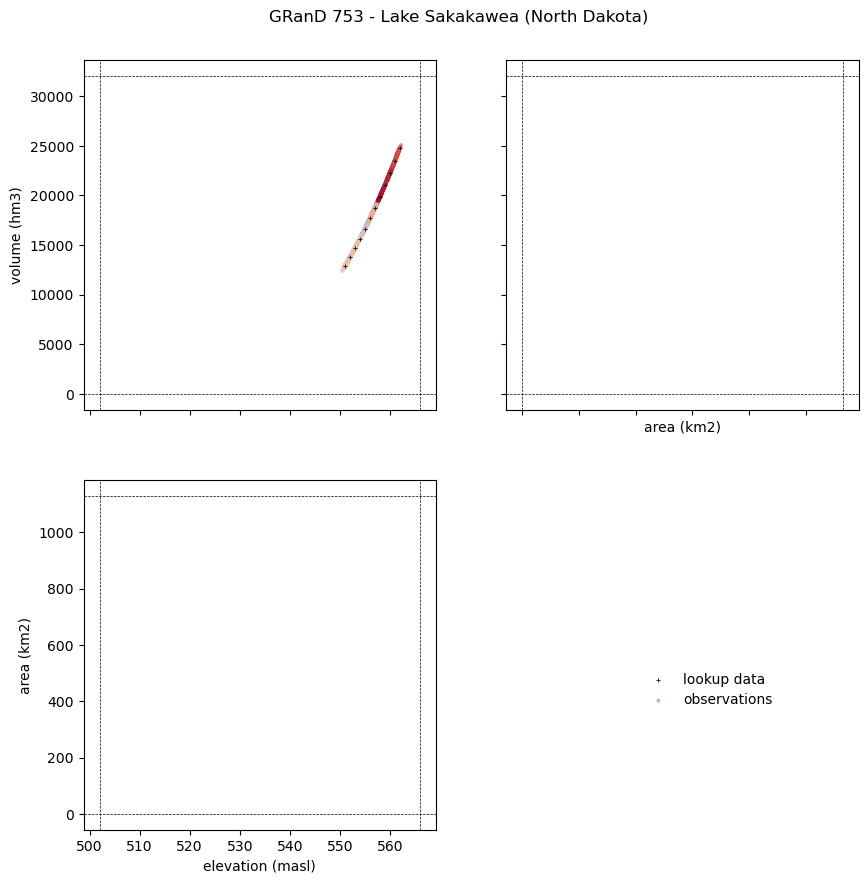

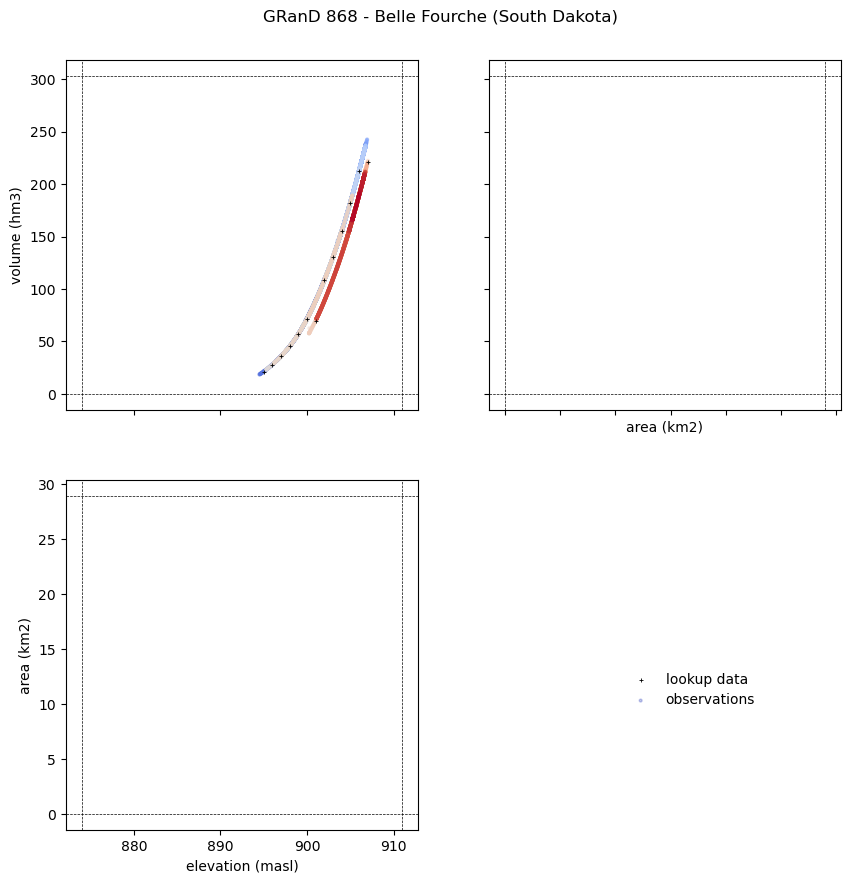

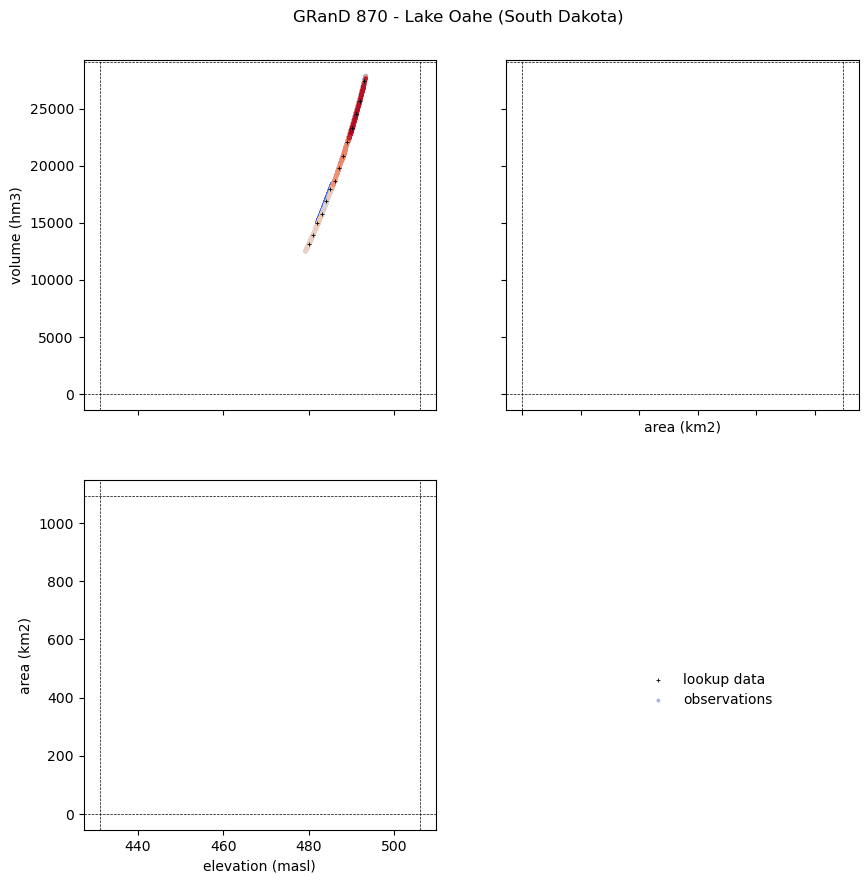

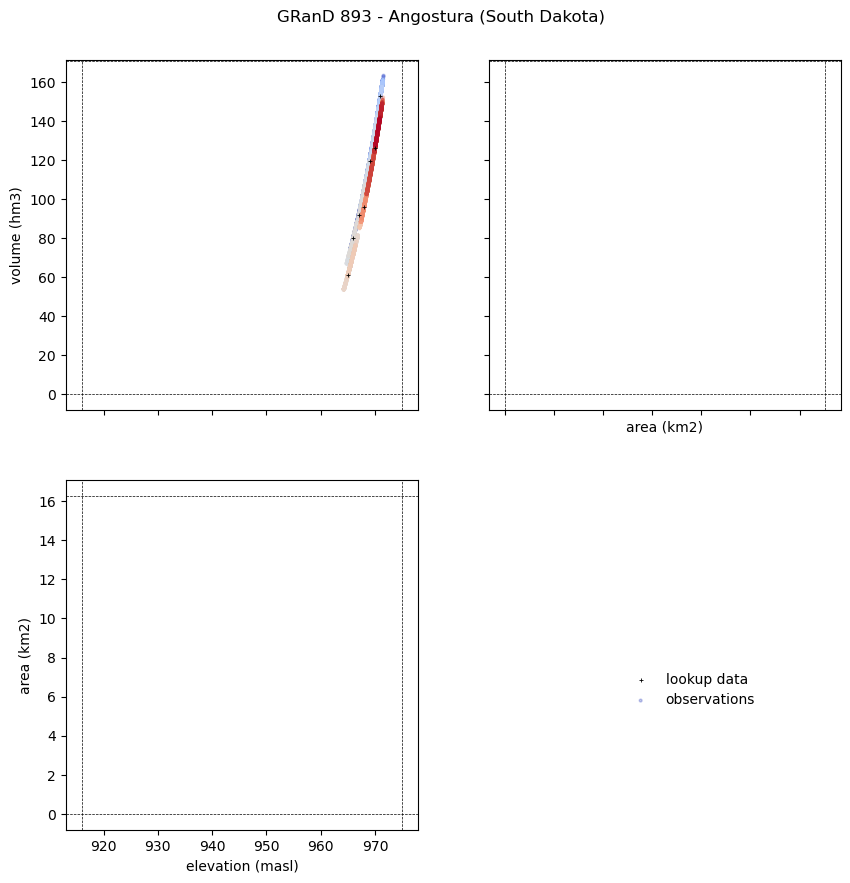

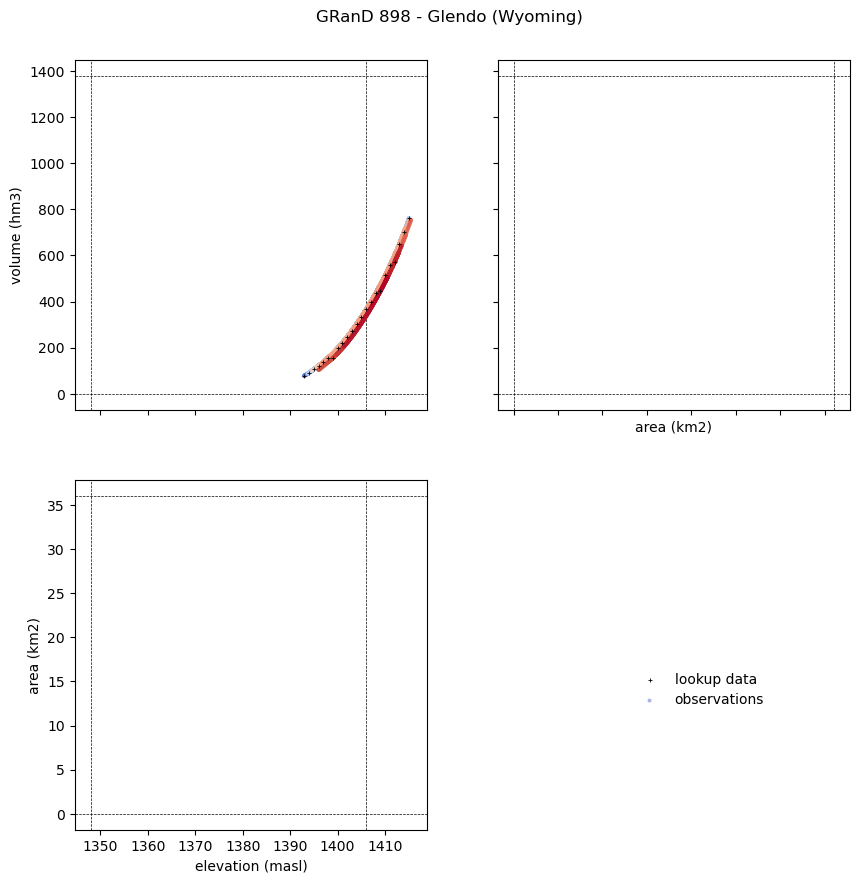

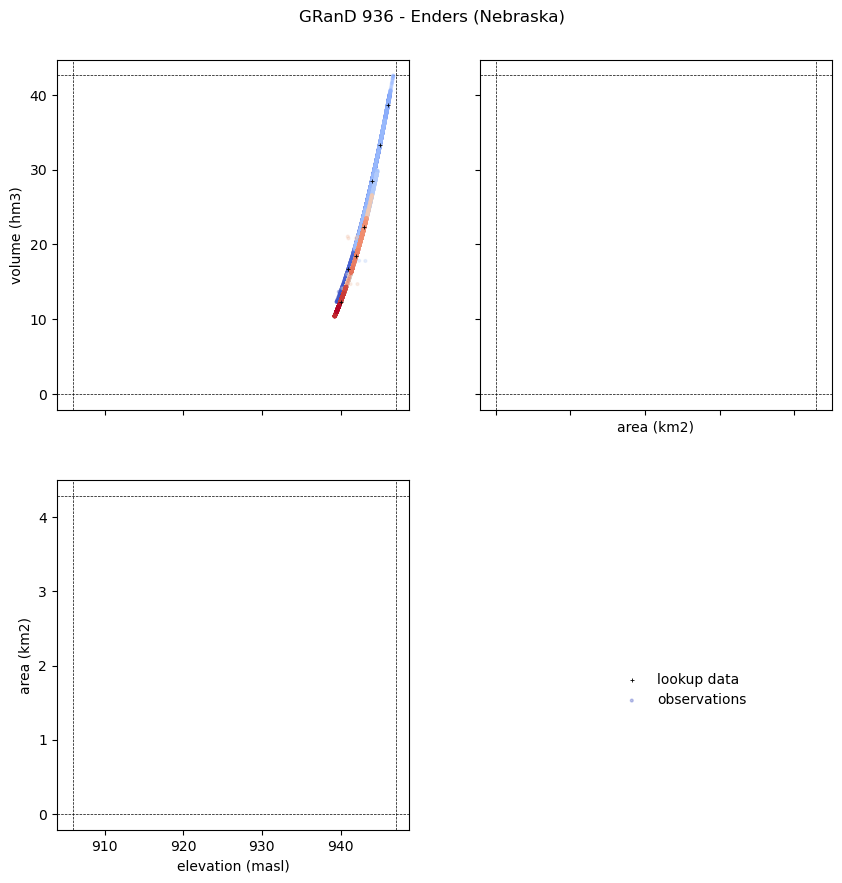

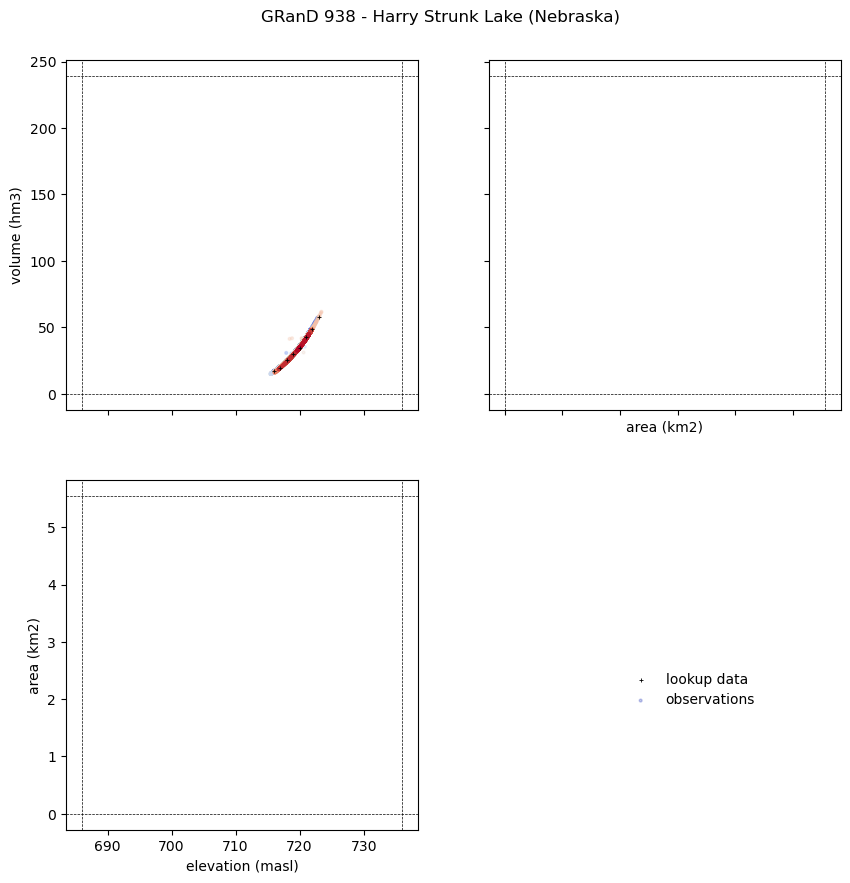

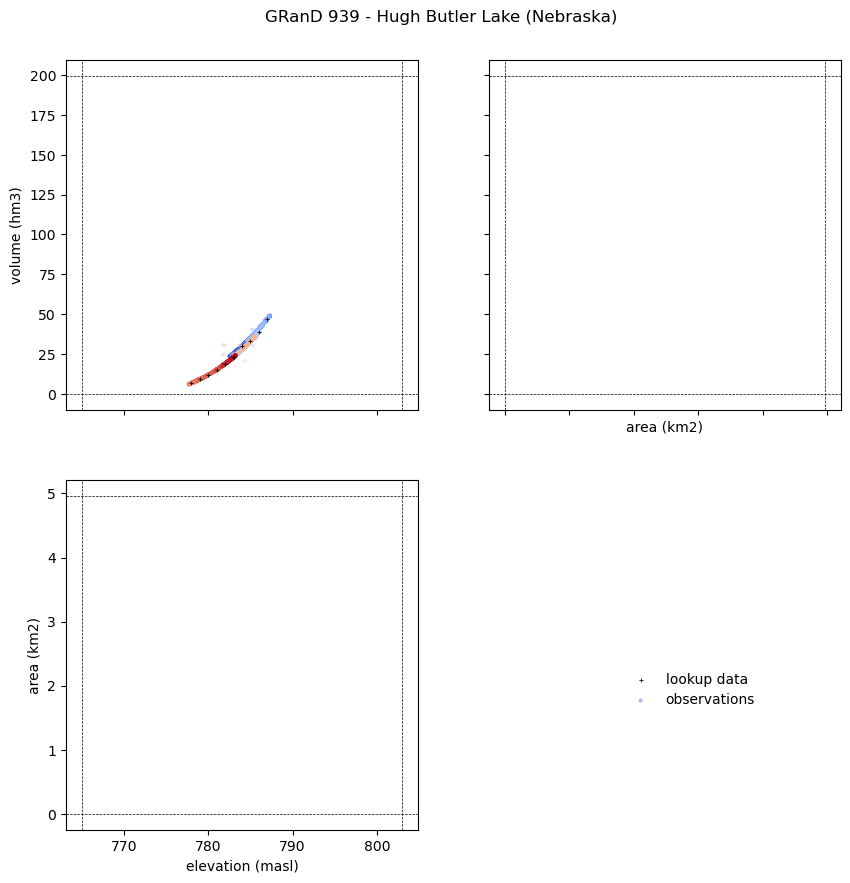

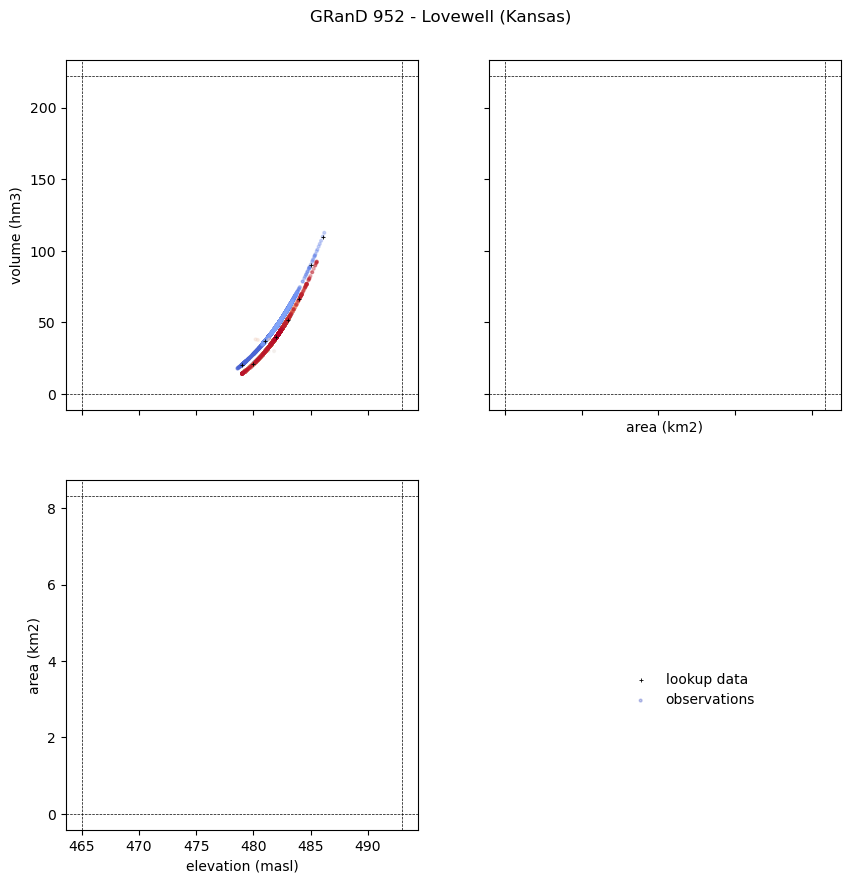

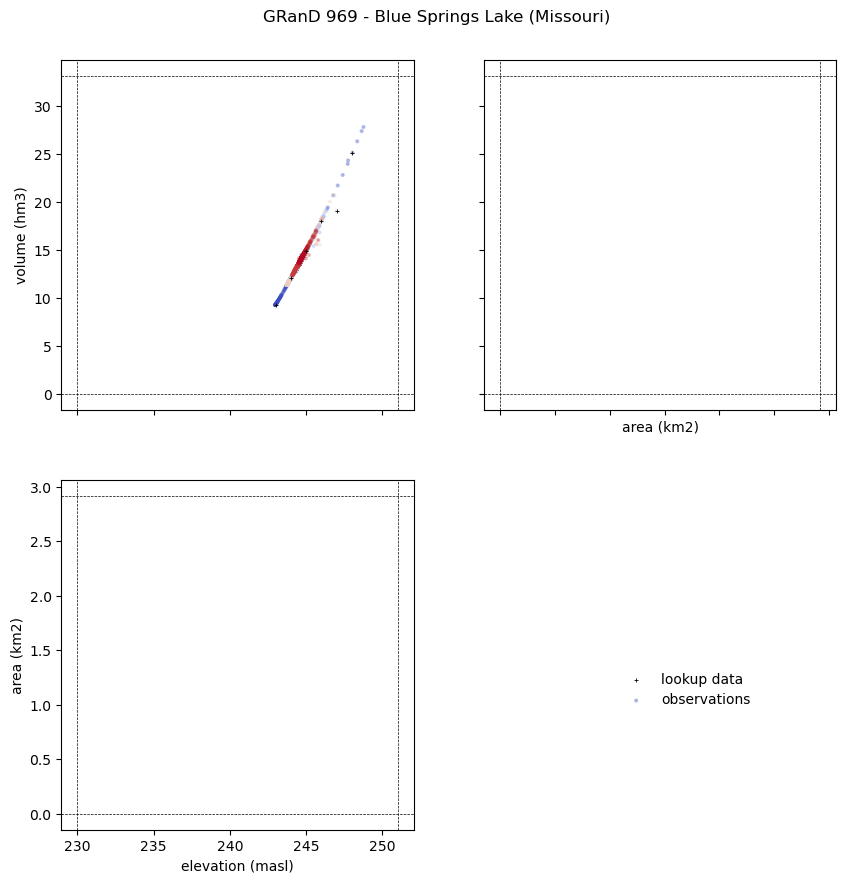

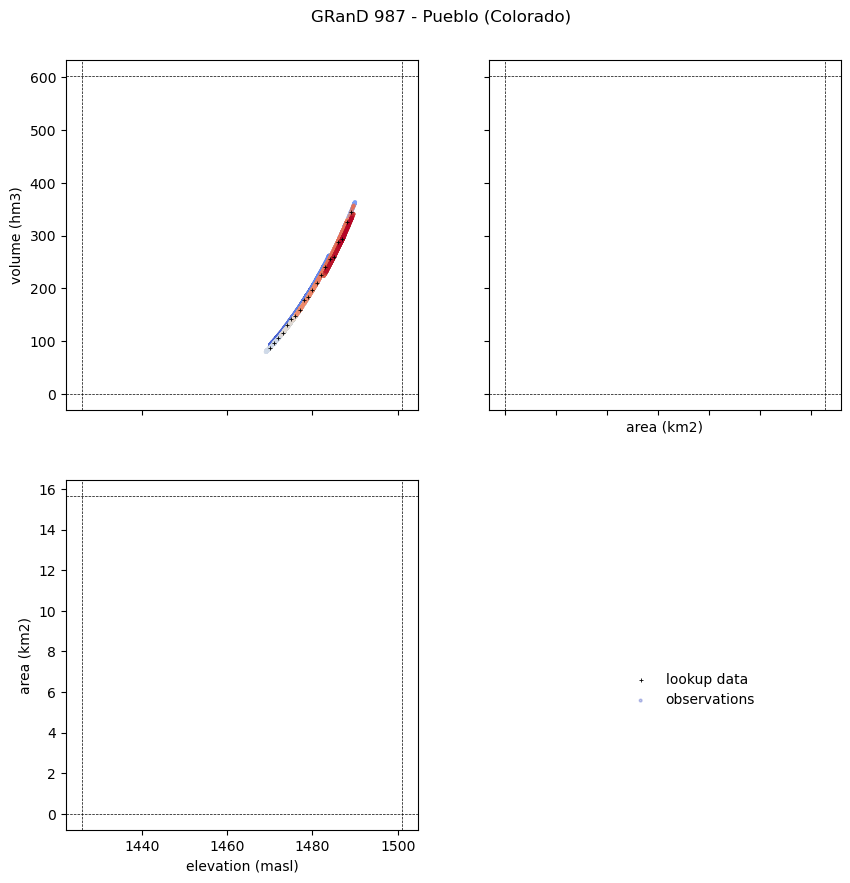

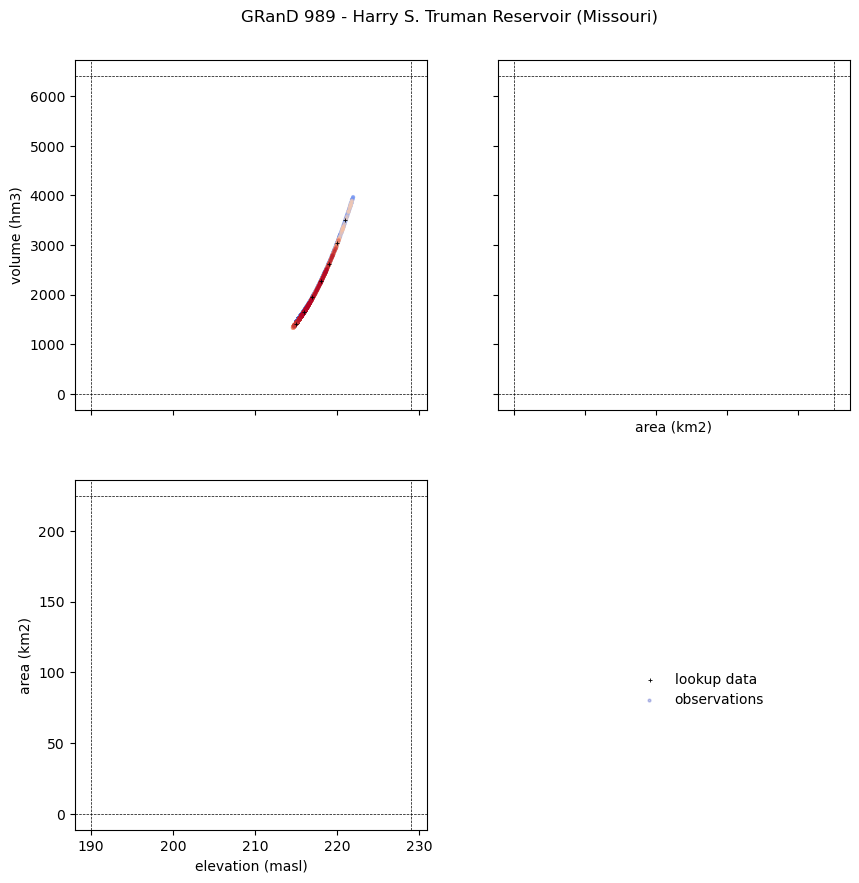

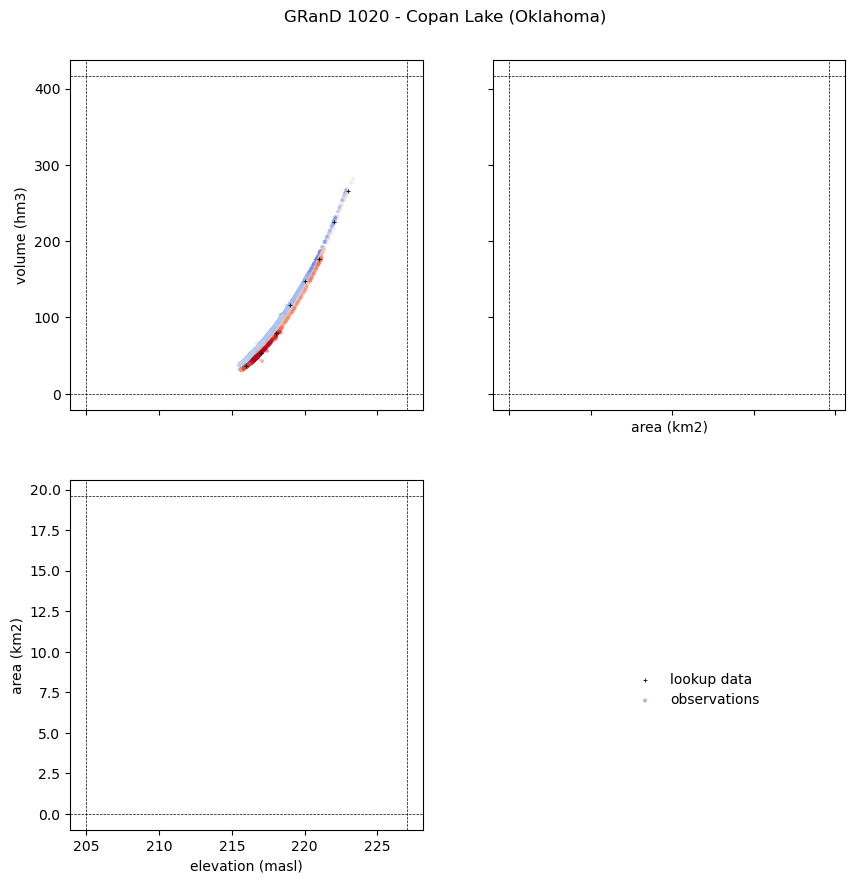

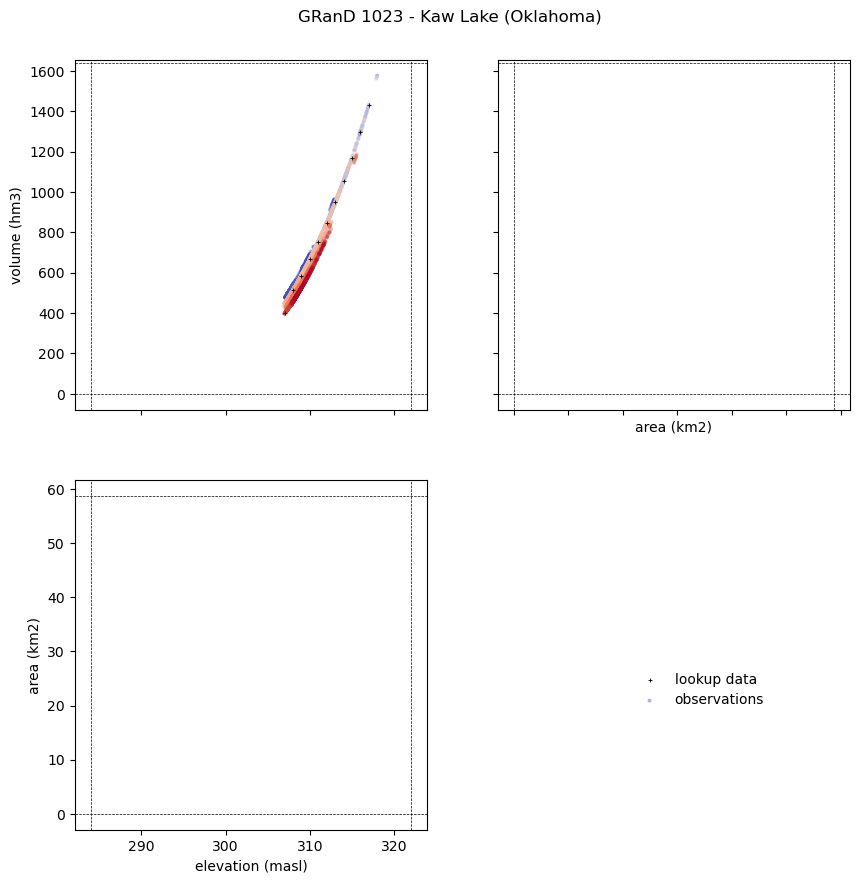

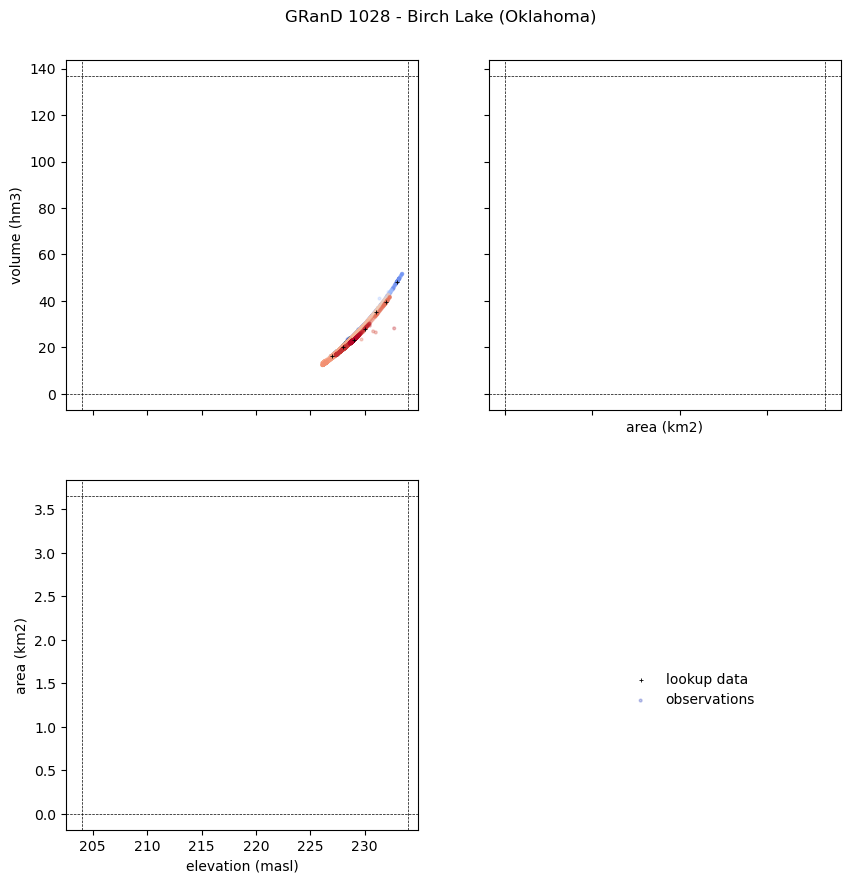

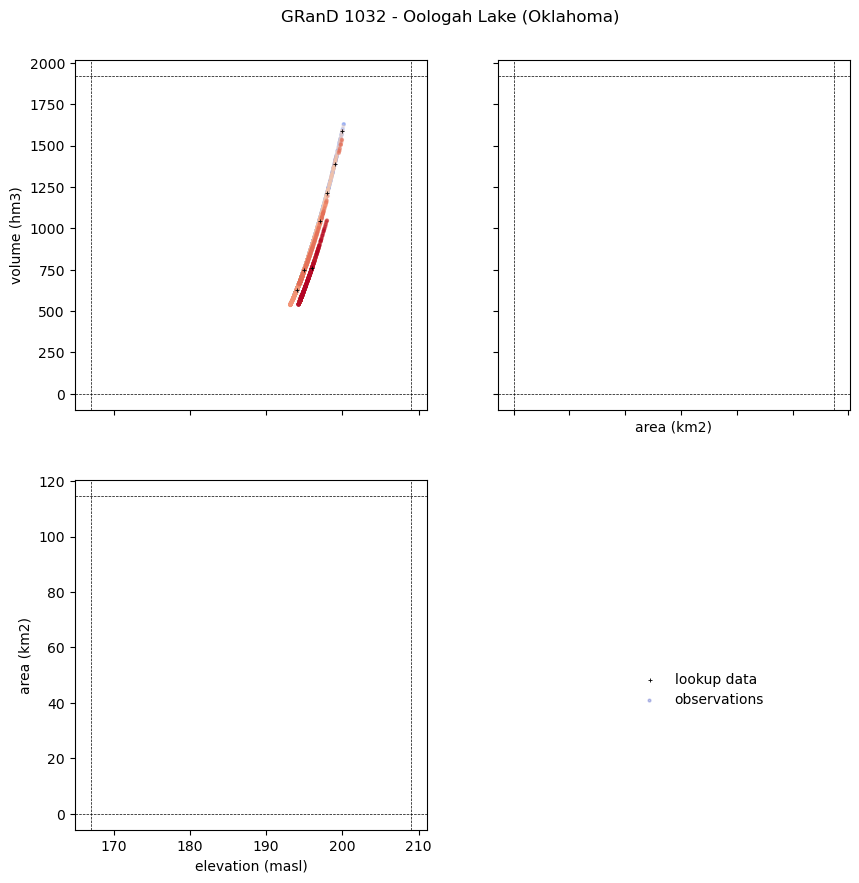

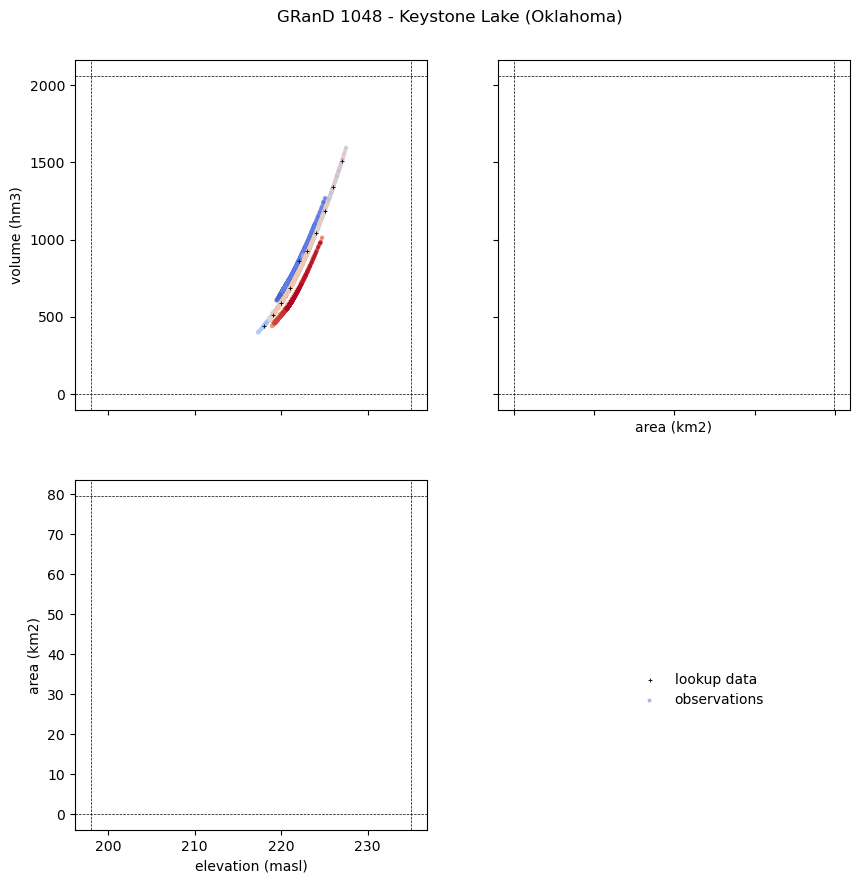

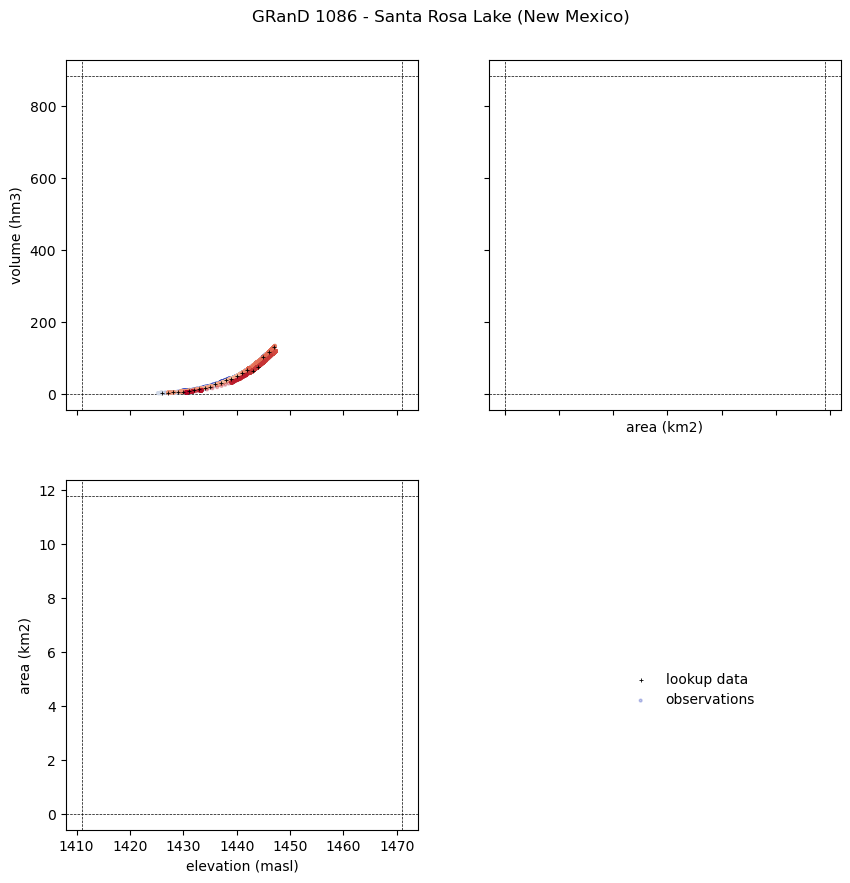

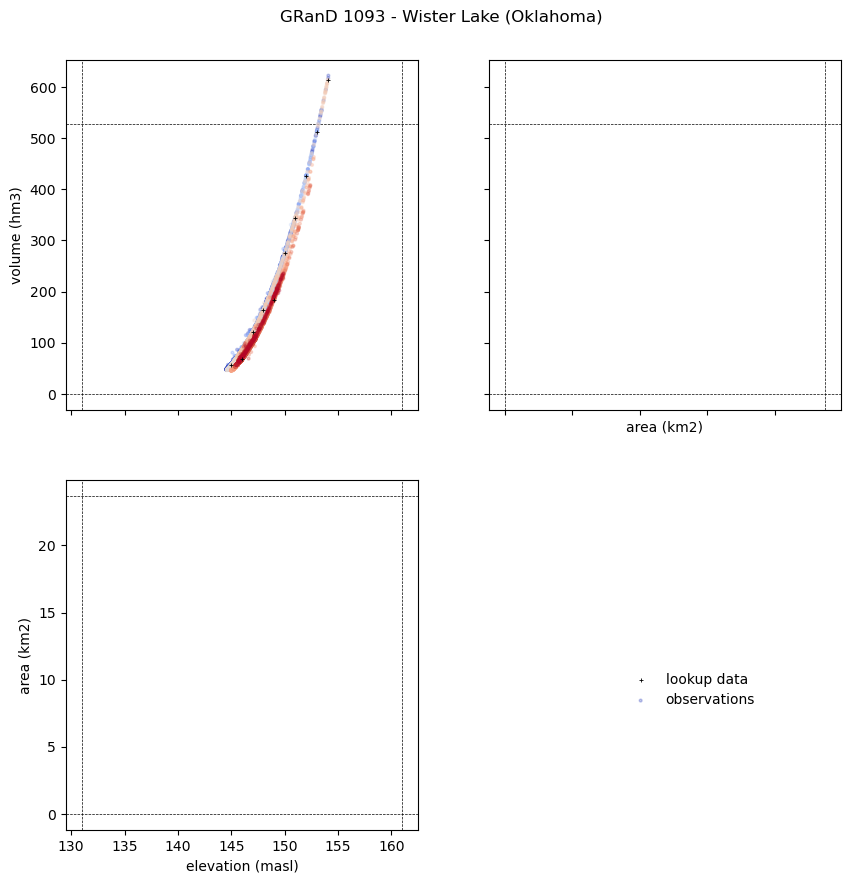

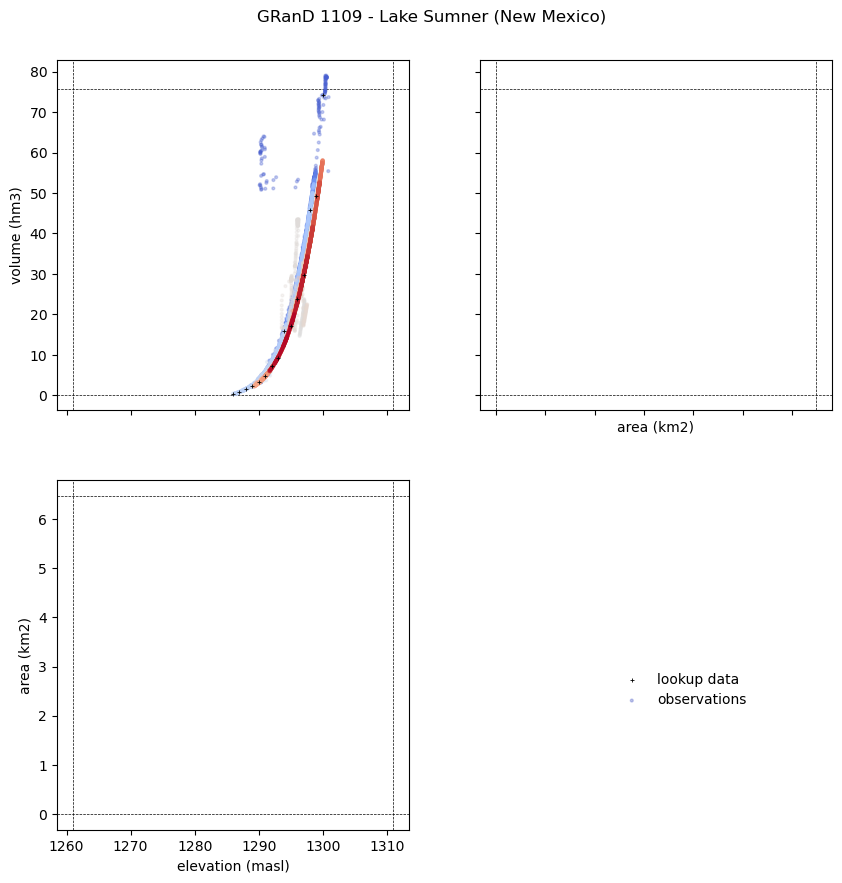

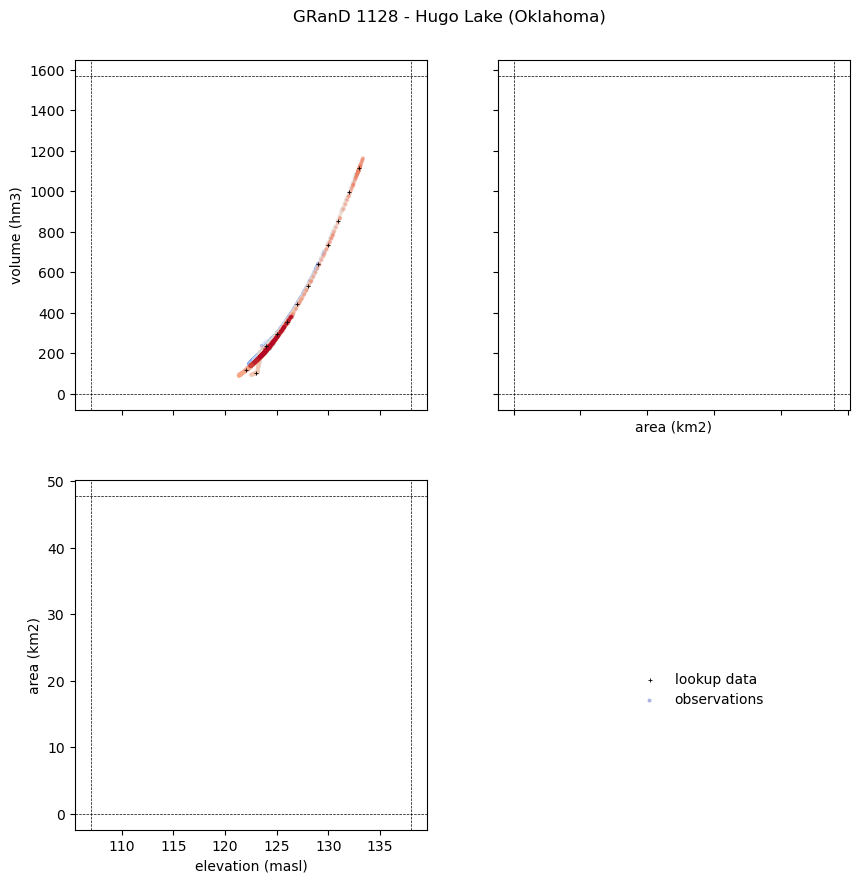

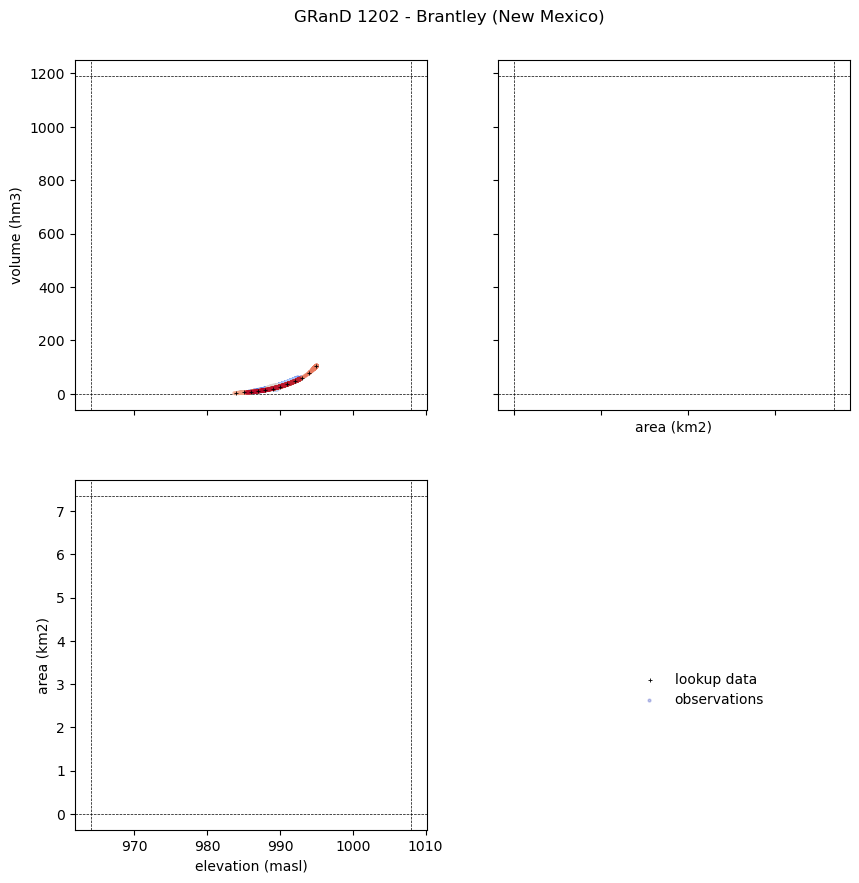

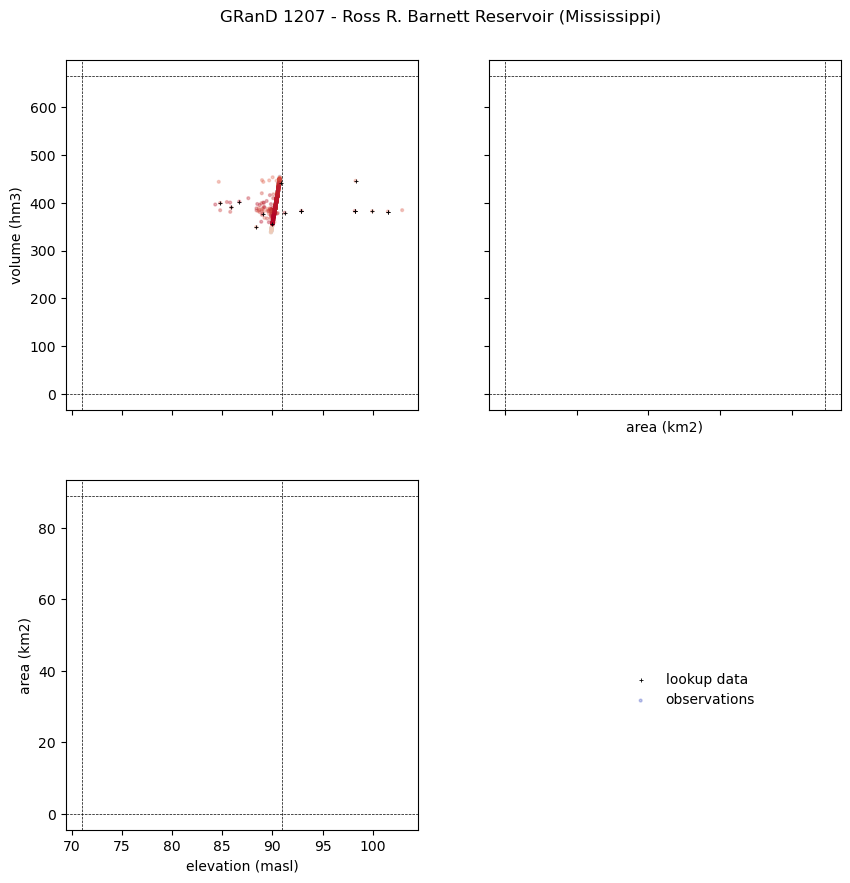

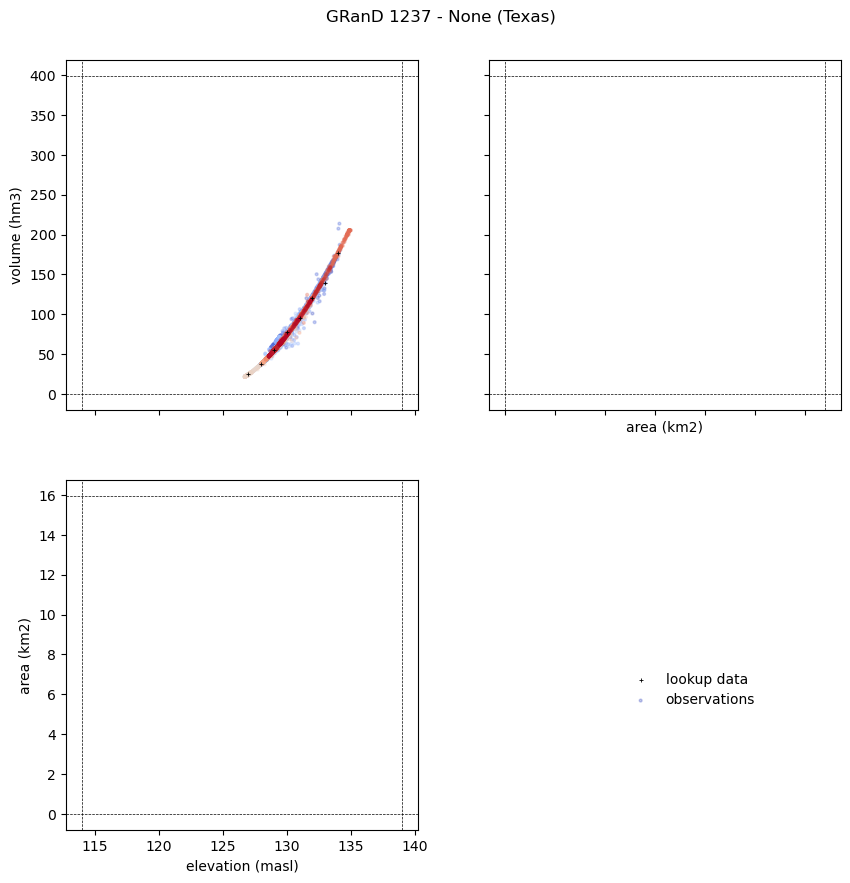

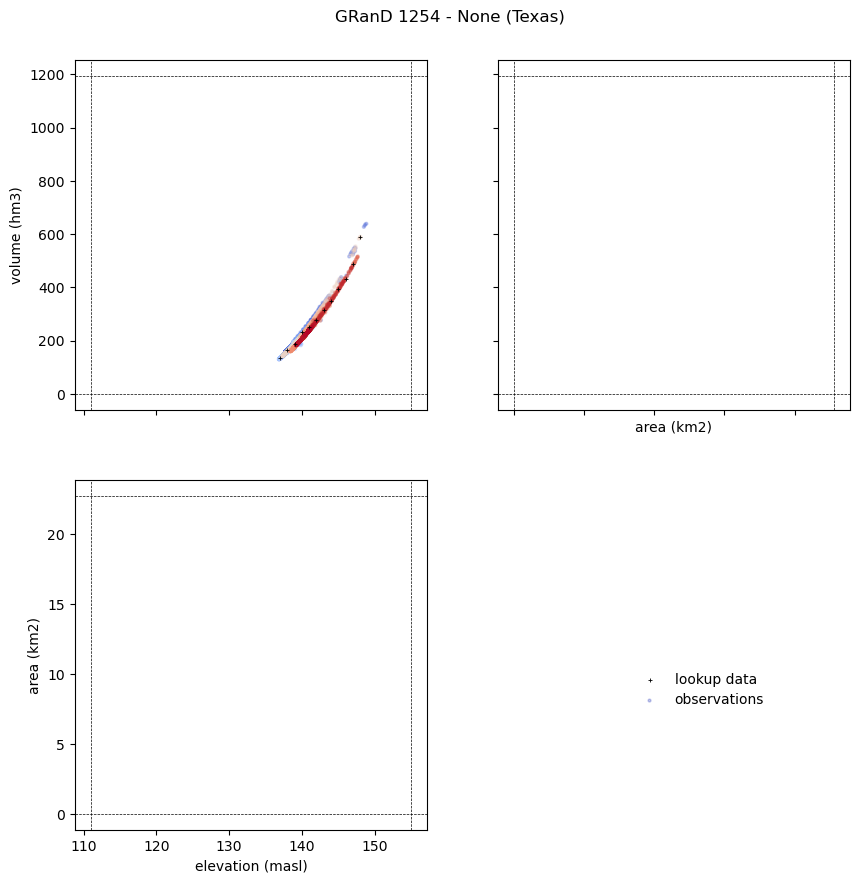

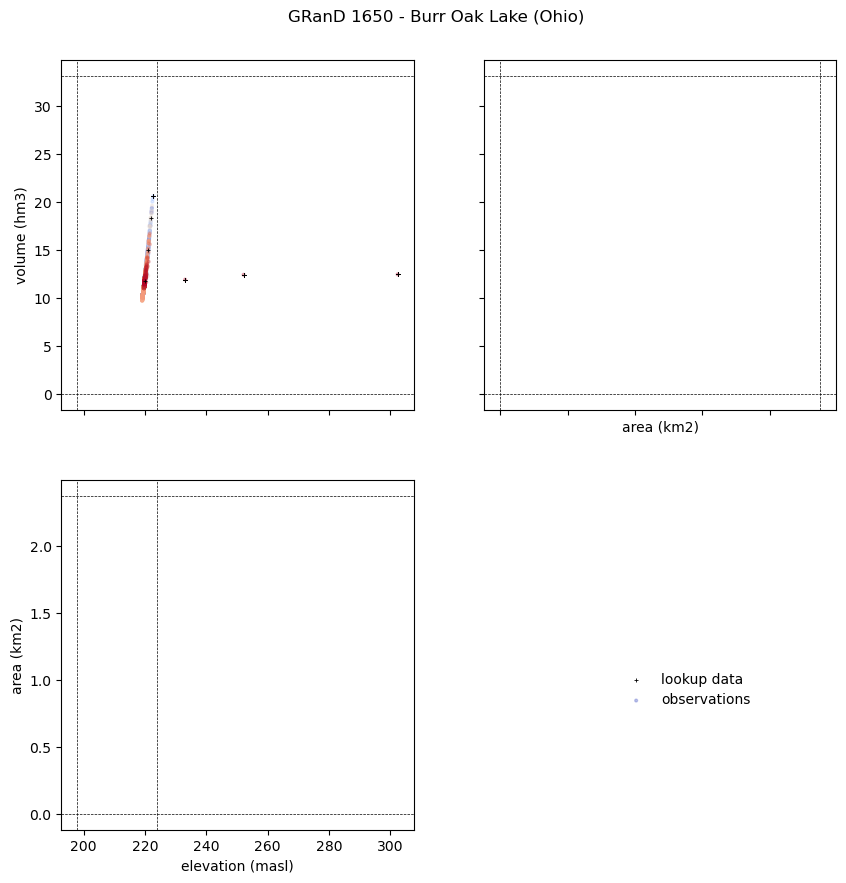

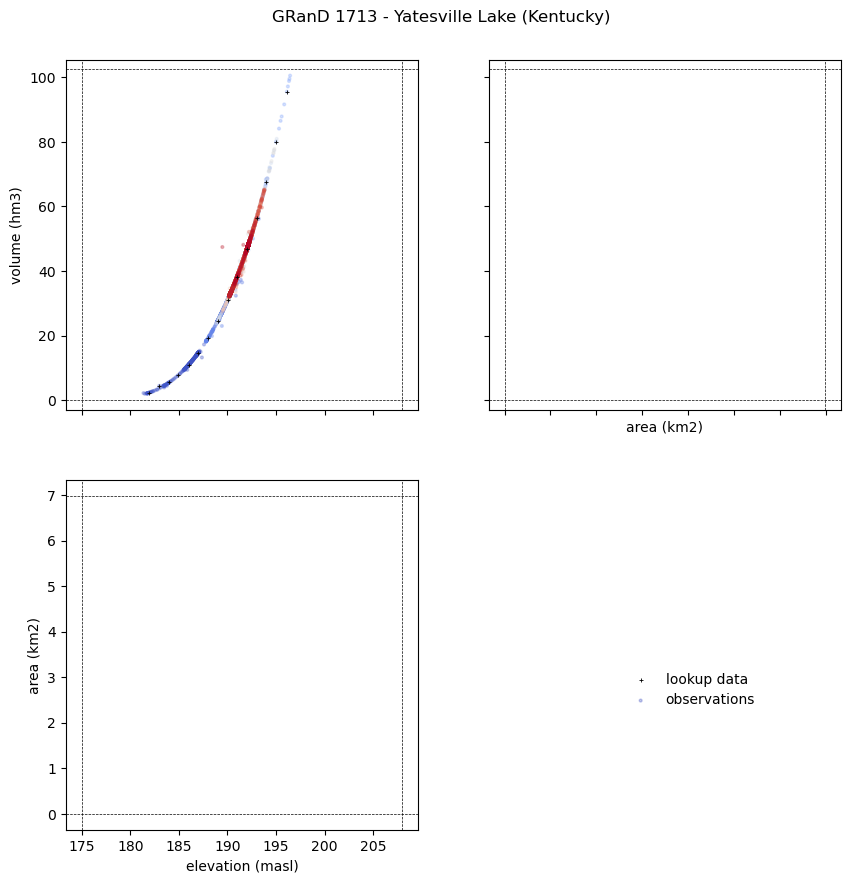

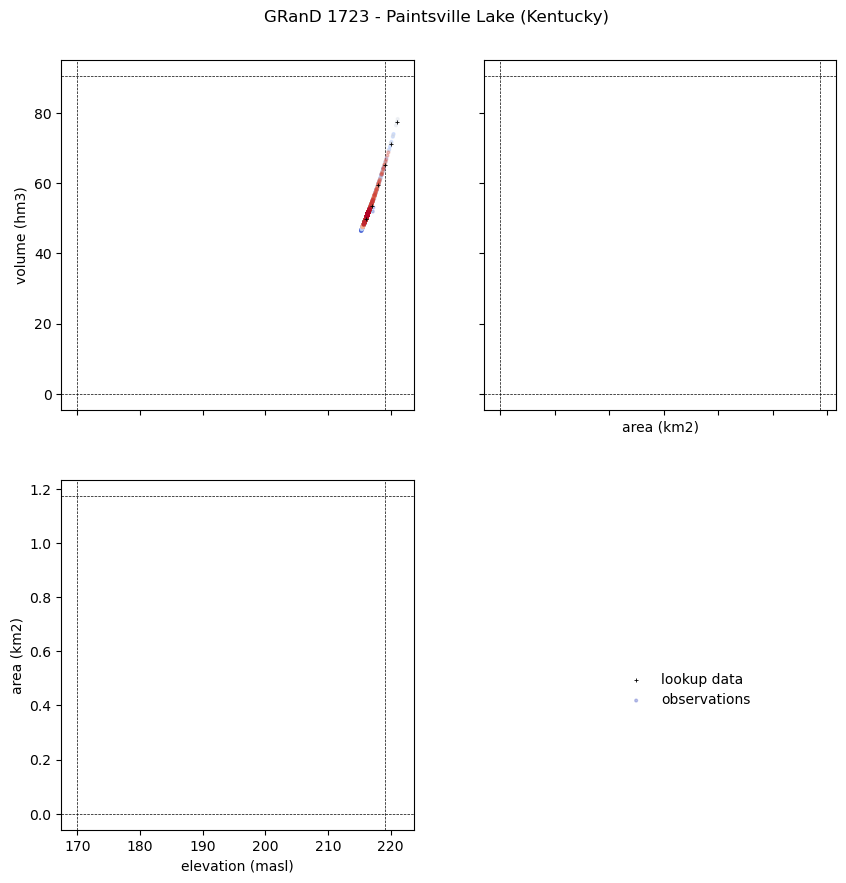

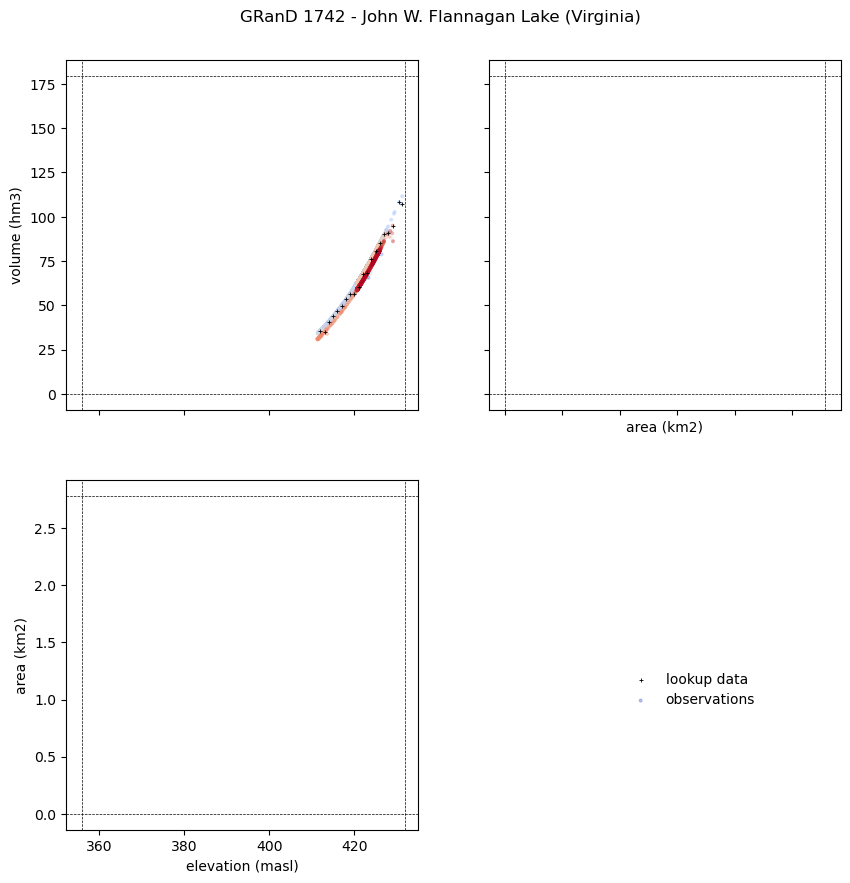

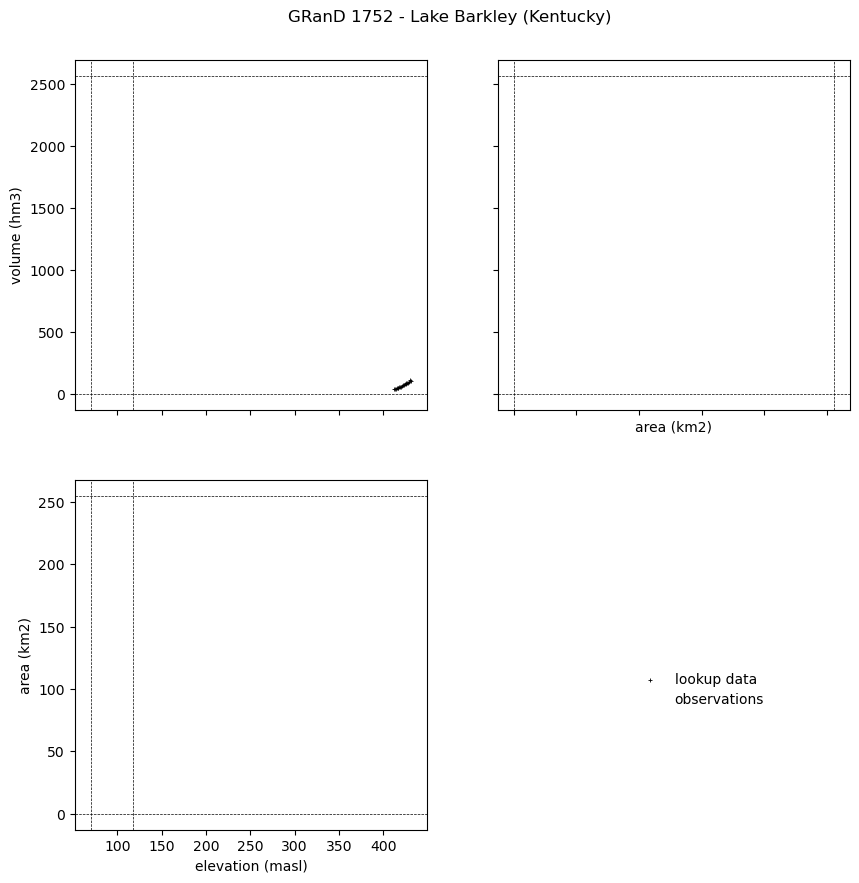

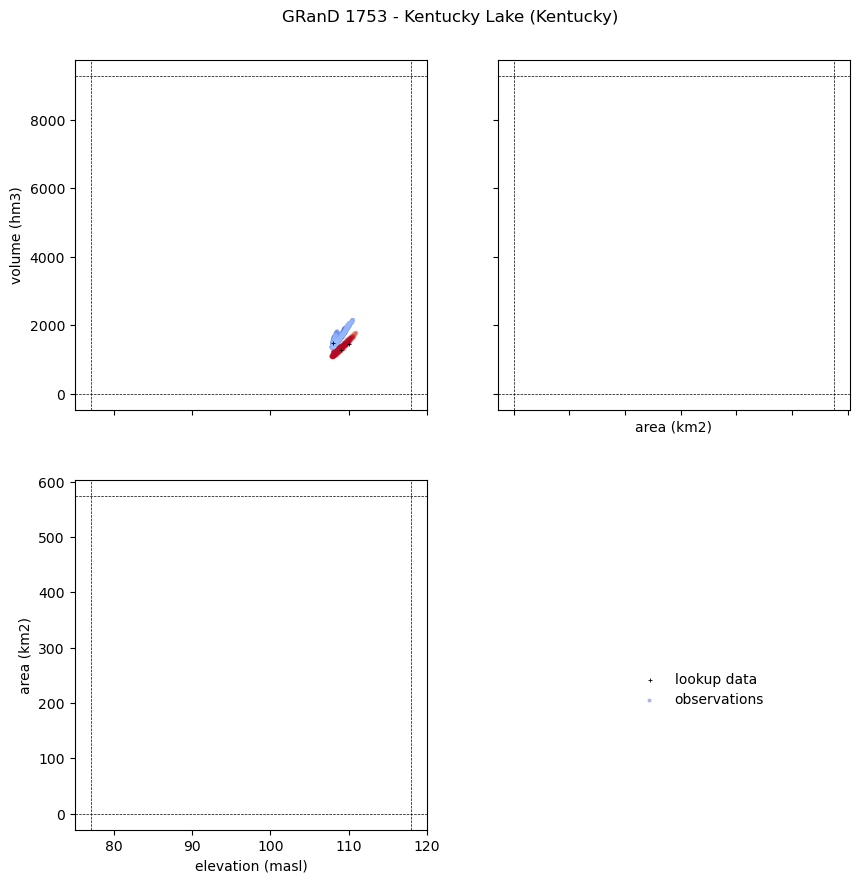

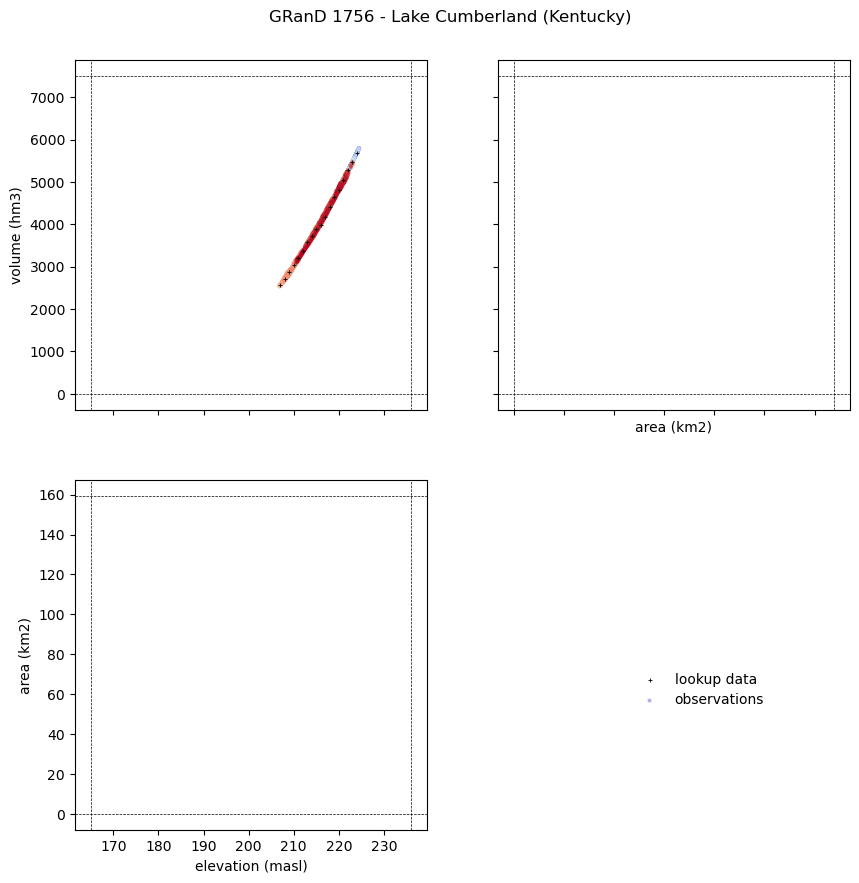

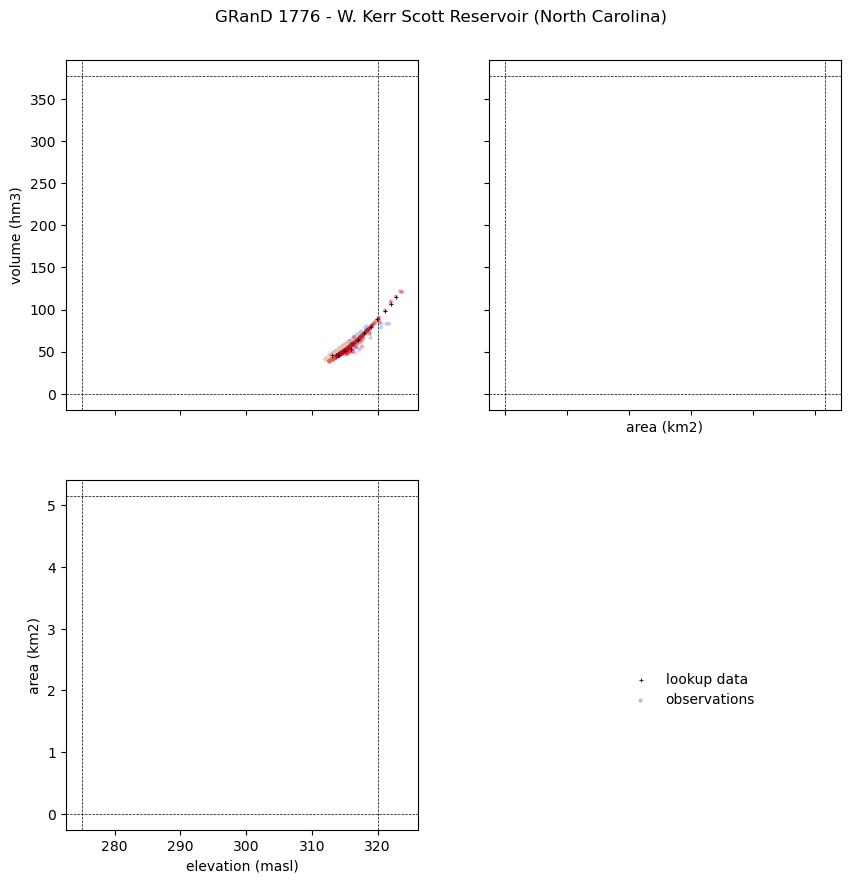

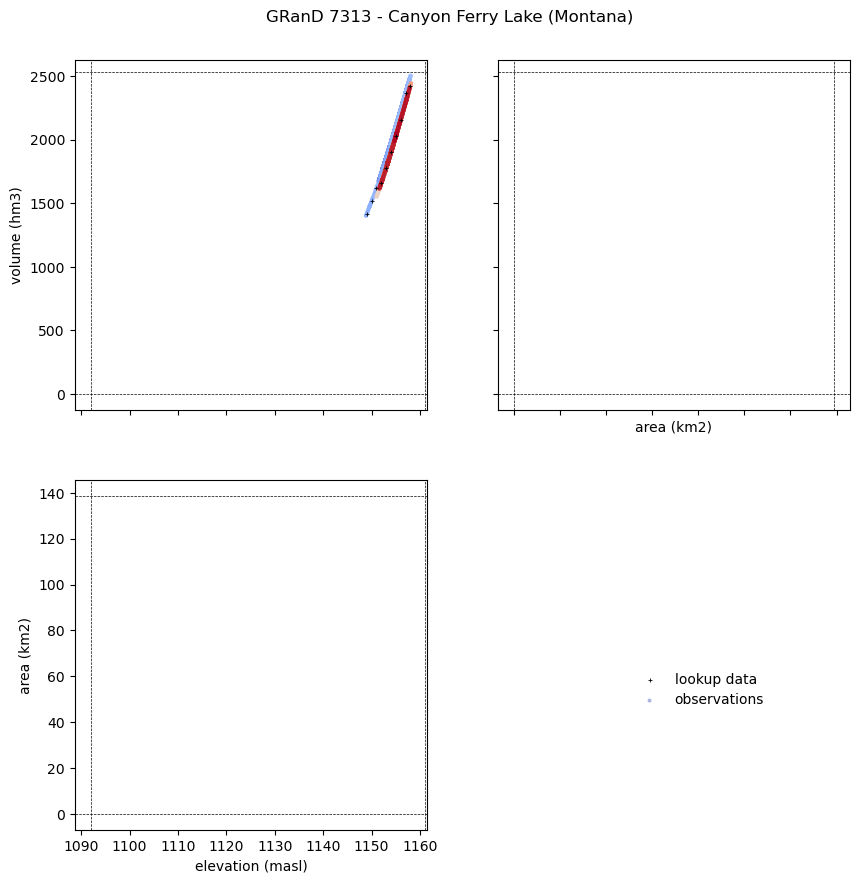

In [234]:
bin_size = 1
threshold_density = 5e-5

grand_ids = sorted(resops_ts.keys())
for grand_id in tqdm(grand_ids):
    pkl_file = path_resops / 'reservoir_curves' / f'{grand_id}.pkl'
    if pkl_file.is_file():
        continue
    else:
        print(f'\nGRanD ID {grand_id}\n-------------')

    if grand_id in periods:
        start, end = [periods[grand_id][x] for x in ['start', 'end']]
    else:
        start, end = datetime(1990, 1, 1), None

    # attributes
    dam_hgt_m, elev_masl, cap_mcm, area_skm = gdw.loc[grand_id, ['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]
    z_min = elev_masl - dam_hgt_m
    title = 'GRanD {0} - {1} ({2})'.format(grand_id, *gdw.loc[grand_id, ['RES_NAME', 'ADMIN_UNIT']])

    # extract data 
    obs = resops_ts[grand_id].loc[start:end].copy()
    obs.dropna(axis=0, how='any', inplace=True)
    
    try:
        # clean outliers
        obs_clean = remove_outliers_kde(obs, 'elevation', 'storage', threshold_density=threshold_density)

        # create lookup table
        lookup_table = bin_data(obs_clean['elevation'], obs_clean['storage'], agg='closest', bin_size=bin_size)

        # initialize reservoir curve
        curve = ReservoirCurve(
            lookup_table,
            z_min=obs_clean.elevation.min(),
            z_max=obs_clean.elevation.max(),
            v_min=obs_clean.storage.min(),
            v_max=obs_clean.storage.max(),
        )

        # fit reservoir curves
        curve.fit(method='pchip')

        # plot
        curve.plot(
            attrs=gdw.loc[grand_id], 
            obs=obs_clean,
            title=title,
            save=path_plots / f'{grand_id}_reservoir_curves.jpg'
        )
        
        # export reservoir curve
        save_curve(curve, pkl_file)

    except Exception as e:
        fig, axes = plot_reservoir_curves(
            lookup_table=lookup_table, 
            attrs=gdw.loc[grand_id], 
            obs=obs_clean,
            title=title,
            )
        print(f'Exception: {e}')
        print('start: {0}\nend: {1}'.format(obs.index.min(), obs.index.max()))
        continue
        break

In [214]:
grand_id, resops_ts[grand_id].index.min(), resops_ts[grand_id].index.max()

(753, Timestamp('1975-01-01 00:00:00'), Timestamp('2020-02-06 00:00:00'))

Points retained (inliers): 6305
Points removed (outliers): 271


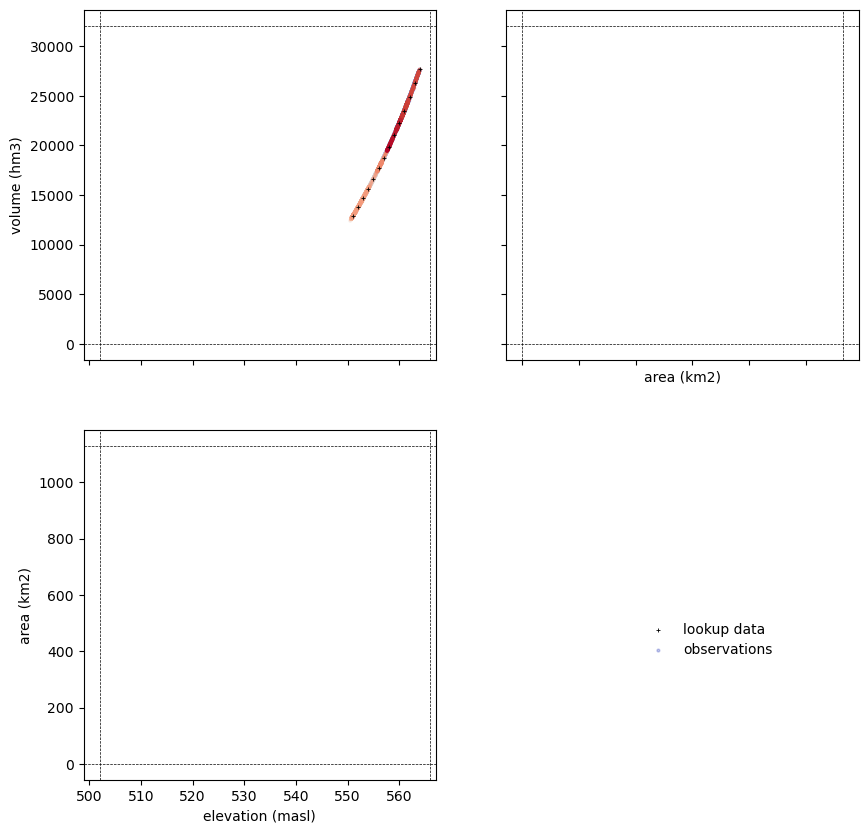

In [226]:
start = datetime(1995, 1, 1)
end = datetime(2013, 1, 1)

# extract data 
obs = resops_ts[grand_id].loc[start:end].copy()
obs.dropna(axis=0, how='any', inplace=True)

# clean outliers
obs_clean = remove_outliers_kde(obs, 'elevation', 'storage', threshold_density=threshold_density)

# create lookup table
lookup_table = bin_data(obs_clean['elevation'], obs_clean['storage'], agg='closest', bin_size=bin_size)

# plot
fig, axes = plot_reservoir_curves(lookup_table=lookup_table, attrs=gdw.loc[grand_id], obs=obs_clean)

### Create lookup table

In [ ]:
# clean outliers
obs_clean = remove_outliers_kde(obs, 'elevation', 'storage', threshold_density=threshold_density)

# create lookup table
lookup_table = bin_data(obs_clean['elevation'], obs_clean['storage'], agg='closest', bin_size=bin_size)

# add maximum and minimum capacity
#if lookup_table.index.max() < elev_masl and lookup_table.storage.max() < cap_mcm:
#    lookup_table.loc[elev_masl, 'storage'] = cap_mcm
#lookup_table.loc[z_min] = 0
#lookup_table.sort_index(inplace=True)

fig, axes = plot_reservoir_curves(lookup_table=lookup_table, attrs=gdw.loc[grand_id], obs=obs_clean)

### `ReservoirCurve` class

In [ ]:
# initialize class
curve = ReservoirCurve(
    lookup_table,
    z_min=obs_clean.elevation.min(),
    z_max=obs_clean.elevation.max(),
    v_min=obs_clean.storage.min(),
    v_max=obs_clean.storage.max(),
)

# fit reservoir curves
curve.fit(method='pchip')

# plot
fig, axes = curve.plot(attrs=gdw.loc[grand_id], obs=obs_clean)
title = 'GRanD {0} - {1} ({2})'.format(grand_id, *gdw.loc[grand_id, ['RES_NAME', 'ADMIN_UNIT']])
fig.suptitle(title, y=0.93);
plt.savefig(path_plots / f'{grand_id}_reservoir_curves.jpg', dpi=300, bbox_inches='tight')

In [ ]:
# export reservoir curve
pkl_file = path_resops / 'reservoir_curves' / f'{grand_id}.pkl'
save_curve(curve, pkl_file)

### Comparison with GWW time series

In [ ]:
gww_ts[grand_id].columns

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(20, 10))

x_min = min(gww_ts[grand_id].index.min(), resops_ts[grand_id].index.min())
x_max = max(gww_ts[grand_id].index.max(), resops_ts[grand_id].index.max())

ax = axes[0]
if 'volume_mcm' not in gww_ts[grand_id]:
    ax.scatter(gww_ts[grand_id].index, curve.storage_from_area(gww_ts[grand_id].area_skm), c='lightsteelblue', s=4, label='estimated from GWW')
else:
    ax.scatter(gww_ts[grand_id].index, gww_ts[grand_id].volume_mcm, c='steelblue', s=4, label='GWW')
ax.plot(resops_ts[grand_id].index, resops_ts[grand_id].storage, c='k', label='observed', zorder=0)
ax.set(
    xlim=(x_min, x_max),
    ylabel='storage (hm3)'
)
ax.legend(frameon=False);

ax = axes[1]
ax.scatter(gww_ts[grand_id].index, gww_ts[grand_id].area_skm, c='steelblue', s=4, label='GWW')
ax.plot(resops_ts[grand_id].index, curve.area_from_elevation(resops_ts[grand_id].elevation), c='gray', label='estimated from observed', zorder=0)
ax.set(
    xlim=(x_min, x_max),
    ylabel='area (km2)'
)
ax.legend(frameon=False);

ax = axes[2]
ax.scatter(gww_ts[grand_id].index, curve.elevation_from_area(gww_ts[grand_id].area_skm), c='lightsteelblue', s=4, label='estimated from GWW')
ax.plot(resops_ts[grand_id].index, resops_ts[grand_id].elevation, c='k', label='observed', zorder=0)
ax.set(
    xlim=(x_min, x_max),
    ylabel='elevation (masl)'
)
ax.legend(frameon=False);

fig.suptitle(title, y=.93);
plt.savefig(path_plots / f'{grand_id}_time_series.jpg', dpi=300, bbox_inches='tight')